In [1]:
import numpy as np

import torch

import torch.nn as nn

import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
# GRU V2 param net

class GRU_WFC_2(nn.Module):
    def __init__(self,tile_num):
        super().__init__()

        self.num_tile = tile_num
        self.inp_channels = tile_num
        self.op_channels = tile_num
        self.k_size = 3
        self.pad_size = 2
        self.p_size = self.k_size//2
        self.bias_scale = 0.25

        expansion_ratio = 3

        self.inter_cv1 = nn.Conv2d(self.num_tile, self.num_tile*expansion_ratio, (1,self.k_size), padding=(0,self.p_size))
        self.inter_cv2 = nn.Conv2d(self.num_tile, self.num_tile//2, (1,self.k_size), padding=(0,self.p_size))
        self.inter_cv3 = nn.Conv2d(self.num_tile*expansion_ratio, self.num_tile, (1,self.k_size), padding=(0,self.p_size))
        self.inter_cv4 = nn.Conv2d(self.num_tile//2, self.num_tile, (1,self.k_size), padding=(0,self.p_size))

        self.inter_ch1 = nn.Conv2d(self.num_tile, self.num_tile*expansion_ratio, (self.k_size,1), padding=(self.p_size,0))
        self.inter_ch2 = nn.Conv2d(self.num_tile, self.num_tile//2, (self.k_size,1), padding=(self.p_size,0))
        self.inter_ch3 = nn.Conv2d(self.num_tile*expansion_ratio, self.num_tile, (self.k_size,1), padding=(self.p_size,0))
        self.inter_ch4 = nn.Conv2d(self.num_tile//2, self.num_tile, (self.k_size,1), padding=(self.p_size,0))

        self.inter_skip = nn.Conv2d(self.num_tile*2, self.num_tile, self.k_size, 1, self.p_size)
        self.inter_skip_gate_e = nn.Conv2d(self.num_tile, self.num_tile*expansion_ratio, self.k_size, 1, self.p_size)
        self.inter_skip_gate_r = nn.Conv2d(self.num_tile*expansion_ratio, self.num_tile, self.k_size, 1, self.p_size)
        self.inter_skip_gate = nn.Conv2d(self.num_tile, self.num_tile, self.k_size, 1, self.p_size)

        self.sigma = torch.nn.Sigmoid()
        self.phi = torch.nn.Tanh()
        self.lRel = torch.nn.LeakyReLU(0.2)
        self.pad = torch.nn.ZeroPad2d(1)

       
    def forward(self, h, key, iter, training, context_vector):

        for i in range(iter):

            h  = self.deep_collapse(h)

            if training:
                if iter == 0:  
                    h_ret = h.clone().unsqueeze(1)
                else:  
                    h_ret = torch.concat((h_ret, h.clone().unsqueeze(1)), dim = 1)

        if training:  
            return h_ret
        else:  
            return h

    def deep_collapse(self, h):
    
        xskipv = h.clone()
        xskiph = h.clone()
        
        v1 = self.inter_cv1(xskipv)
        v2 = self.phi(self.inter_cv3(v1))
        v3 = self.lRel(self.inter_cv2(xskipv))
        v4 = self.sigma(self.inter_cv4(v3))
        xskipv = xskipv * (1 - v4) + v2 * self.bias_scale

        h1 = self.inter_ch1(xskiph)
        h2 = self.phi(self.inter_ch3(h1))
        h3 = self.lRel(self.inter_ch2(xskiph))
        h4 = self.sigma(self.inter_ch4(h3))
        xskiph = xskiph * (1 - h4) + h2 * self.bias_scale

        xskip = torch.concat((xskipv, xskiph), dim=1)
        xskip = self.sigma(self.inter_skip(xskip))
        gate = self.sigma(self.inter_skip_gate(h))
        h = h * (1 - gate) + self.phi(xskip) * gate 

        return h
    

In [3]:
# ACTUAL WFC

def actual_wfc(tile_space, width, height, key, seed, z):

    wave_map = torch.ones((tile_space, width, height))
    collapse_index = torch.zeros(width * height)

    #if seed != None:
    wave_map = wave_map * seed
    collapse_index[z] = 1

    wave_map = diffuse(wave_map, z//width, z%width, key, width, height)

    key = key
    collapsed = False
    count = 0
    if 1:
        while not collapsed:
            id_lin = choose(wave_map, collapse_index)
            if id_lin >= 0:
                cx = id_lin % width
                cy = id_lin // width

                wave_vec = wave_map[:,cy, cx].squeeze() #key_return(wave_map, cy, cx, height, width, key, 4)
                tile = collapse(wave_vec)

                wave_map[:, cy, cx] = tile
                wave_map = diffuse(wave_map, cy, cx, key, width, height)
                
                collapse_index[cx + cy * width] = 1

                if collapse_index.sum() == width * height or count > width*height + 10:
                    collapsed = True
                    if count > width*height + 10:
                        print('out of time')
                    break

                count += 1

    return wave_map

def diffuse(map_, cy, cx, k, w, h):
    cy = int(cy)
    cx = int(cx)
    vec = map_[:, cy, cx].unsqueeze(-1)

    if cy-1 >= 0:
        map_[:, cy-1,cx] = map_[:, cy-1,cx] * (torch.matmul(k, vec).squeeze())#.unsqueeze(-1)
    if cy+1 < h:
        map_[:, cy+1,cx] = map_[:, cy+1,cx] * (torch.matmul(k, vec).squeeze())#.unsqueeze(-1)
    if cx-1 >= 0:
        map_[:, cy, cx-1] = map_[:, cy, cx-1] * (torch.matmul(k, vec).squeeze())#.unsqueeze(-1)
    if cx+1 < w:
        map_[:, cy, cx+1] = map_[:, cy, cx+1] * (torch.matmul(k, vec).squeeze())#.unsqueeze(-1)

    return map_

def collapse(x): 
    # X is current wavespace legality key
    
    probability = torch.softmax(torch.rand_like(x), dim=0) #*torch.softmax(freq, dim=0)
    likelihood = x * probability #torch.matmul(key.T, probability.T)
    _, tile_choice = torch.max(likelihood, dim=0)
    x_collapse = torch.zeros_like(x)
    x_collapse[tile_choice] = 1

    return x_collapse
    

def choose(map_, collapse_list):
    x_sum = torch.sum(map_,dim=0)
    x_sumf = x_sum.flatten()
    v, id = x_sumf.sort()
    idx = -1

    for k in range((v.shape[0])):
        if collapse_list[id[k]] == 0:
            idx = id[k]
            break

    return int(idx)

def validator(x, key):
    valid = True
    vmap = torch.ones_like(x)

    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            tile = int(x[j, i])
            
            if j-1 >= 0:
                if key[tile, int(x[j-1,i])] == 0:
                    valid = False
                    vmap[j,i] -= 1

            if j+1 < x.shape[1]:
                if key[tile, int(x[j+1,i])] == 0:
                    valid = False
                    vmap[j,i] -= 1     

            if i-1 >= 0:
                if key[tile, int(x[j,i-1])] == 0:
                    valid = False
                    vmap[j,i] -= 1

            if i+1 < x.shape[0]:
                if key[tile, int(x[j,i+1])] == 0:
                    valid = False
                    vmap[j,i] -= 1
 

    return valid, torch.clamp(vmap, 0, 1)

def gen_key(num_tiles, h, w):
    map_init = torch.randint(0, num_tiles, (h, w)) # [H, W]
    #  Key format: KEY[VALUE, QUERY] -> query is neighbor, value is us tile, returns validity of us given neighbor

    key = torch.zeros(( num_tiles, num_tiles))# [1, N, N]
    for j in range(w):
        for i in range(h):
            
            if i+1 < h:
                key[map_init[i, j], map_init[i+1, j]] = 1 
            if i-1 >= 0:
                key[map_init[i, j], map_init[i-1, j]] = 1 

            if j+1 < w:
                key[map_init[i, j], map_init[i, j+1]] = 1 
            if j-1 >= 0:
                key[map_init[i, j], map_init[i, j-1]] = 1 

    return key

def gen_seed(num_tiles, height, width):
    seed = torch.ones((num_tiles, width, height))
    xy = torch.randint(0, height, (2,1))
    z = torch.randint(0, num_tiles, (1,1))
    seed[:,xy[0], xy[1]] = seed[:,xy[0], xy[1]]*0
    seed[z,xy[0], xy[1]] = 1

    return seed, xy[1]+xy[0]*width

def gen_map(key, h, w, nt):

    iter = 0
    valid = False

    while valid == False:
        valid = False
        seed, z = gen_seed(nt, h, w)
        map_ = actual_wfc(nt, w, h, key, seed, z).squeeze()
        val, id = torch.max(map_.flatten(-2,-1),dim=0)
        id_map = id.reshape(h,w)
        valid, vmap = validator(id_map, key)
        iter += 1
    
    return map_, id_map


In [4]:
# DIFFUSION CLASS 

"""
This class is still used for generating the input noise for each training map, though no actuall diffusion method is used in training right now

"""

class diffusion():
    def __init__(self):
        self.num_diffusion_timesteps=1000
        scale = 1000 / self.num_diffusion_timesteps
        beta_start = scale * 1e-4
        beta_end = scale * 0.02
        beta = torch.linspace(
            beta_start,
            beta_end,
            self.num_diffusion_timesteps,
        )

        beta = torch.clamp(beta, 0, 0.999)

        self.alpha = 1 - beta
        self.self_sqrt_beta = torch.sqrt(beta)
        self.alpha_cumulative = torch.cumprod(self.alpha, dim=0)
        #alpha_cumulative = torch.clamp(alpha_cumulative, 0, 0.999)
        self.sqrt_alpha_cumulative = torch.sqrt(self.alpha_cumulative)
        self.one_by_sqrt_alpha = 1. / torch.sqrt(self.alpha)
        self.sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - self.alpha_cumulative)


    def forward_diffusion(self, x0, timesteps, beta_time, epsilon_prior = 0):

        if epsilon_prior.sum() == 0: # We diffuse forward, then check for entropy threshold, then if exceeded we go back in time and idffuse new keys forwar as well with same epsilon
            eps = torch.rand_like(x0) 
        else:
            eps = epsilon_prior
        
        indices = timesteps[beta_time]
        mean = self.sqrt_alpha_cumulative[indices] * x0  # Map scaled
        std_dev = self.sqrt_one_minus_alpha_cumulative[indices] # Noise scaled
        sample  = mean + std_dev * eps # scaled inputs * scaled noise

        return sample, eps

    def do_diffusion(self, x0, key):
        
        # x0 is a 3d

        noisy_images = x0.squeeze().clone().unsqueeze(0)
        xts_threshold = x0.clone()
        xts = x0.clone()

        specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999] # This less represents the "timesteps" in diffusion and more the "rate" of diffusion. 
        timestep = torch.as_tensor(specific_timesteps, dtype=torch.long)
        beta_index = timestep.shape[0]
        beta_time = torch.zeros_like(x0)
        z = torch.zeros(1)
        #beta_time = torch.as_tensor(beta_time, dtype=torch.long)

        x_key_mask = self.uncollapse(x0.clone(), key)

        diffusing = True
        itr = 0
        while diffusing:
            xPrior = xts
            betaPrior = beta_time.clone()

            # Take forward diffusion step
            xts, eps = self.forward_diffusion(xPrior.clone(), timestep, torch.as_tensor(beta_time, dtype=torch.long), z)

            # Update mask according to entropy threshold -> uncollapse valididty 
            xts_threshold[beta_time >= 3] = 1
            x_key_mask = self.uncollapse(xts_threshold, key) 
            beta_time += torch.ones_like(beta_time) * x_key_mask
            beta_time = torch.clamp(beta_time, 0, beta_index-1)

            # "re-perform" diffusion using retcon'd beta index
            xts, _ = self.forward_diffusion(xPrior.clone(), timestep, torch.as_tensor(beta_time, dtype=torch.long), eps)

            noisy_images = torch.concat((xts.unsqueeze(0), noisy_images), dim = 0)

            itr += 1

            if betaPrior.sum() == beta_time.sum():
                # Beta time will increase each loop as we march through diffusion, but will stay static when we finish or cannot uncollapse any more
                diffusing = False

        return noisy_images, itr
    
    def uncollapse(self, wave_map, key):
        diff_map = torch.ones_like(wave_map)

        for i in range(wave_map.shape[1]):
            for j in range(wave_map.shape[2]):
                
                if j-1 >= 0:
                    diff_map[:,j,i] += diff_map[:,j,i]*(torch.matmul(key, wave_map[:, j-1, i]))#/wave_map[:, j-1, i].sum())

                if j+1 < wave_map.shape[1]:
                    diff_map[:,j,i] += diff_map[:,j,i]*(torch.matmul(key, wave_map[:, j+1, i]))#/wave_map[:, j+1, i].sum())
                        
                if i-1 >= 0:
                    diff_map[:,j,i] += diff_map[:,j,i]*(torch.matmul(key, wave_map[:, j, i-1]))#/wave_map[:, j, i-1].sum())

                if i+1 < wave_map.shape[2]:
                    diff_map[:,j,i] += diff_map[:,j,i]*(torch.matmul(key, wave_map[:, j, i+1]))#/wave_map[:, j, i+1].sum())

        for k in range(wave_map.shape[0]):
            for i in range(wave_map.shape[1]):
                for j in range(wave_map.shape[2]):
                    if diff_map[k,j,i] >= 4:
                        diff_map[k,j,i] = 1
                    else:
                        diff_map[k,j,i] = 0


        return diff_map




/var/folders/d6/9_0p0ctd5cd5q3f8lhpbzpc40000gn/T/ipykernel_12974/1638094077.py:12: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  wave_map = diffuse(wave_map, z//width, z%width, key, width, height)


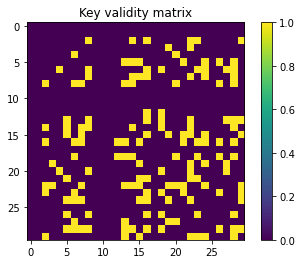

In [5]:
# Data loading block: Generate key, Generate maps, Diffuse maps



df = diffusion()


train_size = 100
num_tiles = 30
height = 3
width = 3
key = gen_key(num_tiles, 6, 6)
key = gen_key(num_tiles, 8, 8)
maps_training = torch.zeros(train_size, 50, num_tiles, height, width)
diffusion_steps = torch.zeros(train_size)
plt.imshow(key.squeeze().numpy())
plt.title('Key validity matrix')
plt.colorbar()
with torch.no_grad():
    for m in range(train_size):
        x, i_l = gen_map(key, height, width, num_tiles)
        
        #for d in range(manifold_count):
        df_unroll, itr = df.do_diffusion(x, key)
        

        if itr < 50:
            maps_training[m, 0:itr+1, :, :, :] = df_unroll.clone()
            diffusion_steps[m] = itr

        else:
            print('whoops')


In [ ]:
# TRAIN LOOP

epochs = 1000
width = width = 3 #map_w
height = height = 3 #map_h
num_tiles = num_tiles
diffusion_steps_GRU = 13
steps = 8
step_size = 5
kernel_size = 3
l_sum_np = 0
batch_size = 1
loss = 0
count = 1
threshold = 0.92
test_len = 100
prev_max = 4.5 # Initial threshold before we start dropping the LR. We don't want to drop it aggresively until at least half the test tiles placed are valid

curriculum = True
switch = True

index_list = np.arange(train_size)
id_list = np.arange(width)
index = np.arange(width*height)

index_even = np.arange(5)*2
index_odd = np.arange(4)*2+1

#gru = GRU_WFC(num_tiles, 0, height, width, diffusion_steps_GRU, kernel_size, bias_sca+le = 0.25, deep = False)
gru = GRU_WFC_2(num_tiles)
device = 'cuda:0'
#gru.to(device)

loss_func =  nn.MSELoss() # nn.L1Loss() #
l_kl = torch.nn.KLDivLoss(reduction="batchmean", log_target = True)
lbce = nn.BCEWithLogitsLoss()

#loss_l1 = nn.L1Loss()
optimizer = torch.optim.NAdam(gru.parameters(), lr = 0.0005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.79)

map_ = torch.zeros(train_size, num_tiles, height, width)
for ii in range(train_size):
    map_[ii] = maps_training[ii, int(diffusion_steps[ii]), :, :, :]


_, id_set = torch.max(map_, dim = 1)

va, m = (torch.var_mean(id_set.float(), 0))
print('The training dataset has a mean tile choice of ', m.mean(),'with a mean std of', va.mean().sqrt())

for epoch in range(epochs):
    loss = 0
    v_ratio = 0
    np.random.shuffle(index_list)

    for i1 in range(train_size):
        
        with torch.no_grad():
            id = index_list[i1]
            dfinal = diffusion_steps[id]
            h_init = maps_training[id, 0:int(dfinal)+1]

        if curriculum:
            # Replaces a random tile with a noise vector. Curriculum adds another instance of noise when [% valid choices > 0.9]
            np.random.shuffle(index)
            h_init = h_init.requires_grad_(False)
            fmap = h_init[int(dfinal)].squeeze().clone()

            for k in range(len(index_even)):
                id_lin = index_even[k]
                with torch.no_grad():
                    id_x = id_lin % width
                    id_y = id_lin // height
                    mask = h_init[0,:,id_x,id_y].cpu().clone()
                    fmap[:,id_x,id_y] = fmap[:,id_x,id_y]*0 + mask

            for k in range(count-1):
                id_lin = index_odd[k]
                with torch.no_grad():
                    id_x = id_lin % width
                    id_y = id_lin // height
                    mask = h_init[0,:,id_x,id_y].cpu().clone()
                    fmap[:,id_x,id_y] = fmap[:,id_x,id_y]*0 + mask
            
                    
            h_init = h_init.requires_grad_(True)
            fmap = fmap.unsqueeze(0)

        map_wfc_retained = gru.forward(fmap, key, 10, False, 0).squeeze() #int(dfinal[m]), training = False).squeeze()
        lv = loss_func(map_wfc_retained, h_init[int(dfinal)]) / count
        loss += lv

        # Summing valid tiles
        with torch.no_grad():
            _, id_pred = torch.max(map_wfc_retained.clone().cpu().detach(), dim = 0)
            _, v = validator(id_pred, key)
            v_ratio += torch.clamp(v, 0, 1).sum()/(height*width)

        l_sum_np += lv.clone().cpu().detach().numpy()
        if (batch_size == 1) or (i1%batch_size == 0 and i1 > 0):
            loss = loss/batch_size
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            del loss
            loss = 0
    
    if (epoch+1)%10 == 0:
        vsum = torch.zeros(test_len, height, width)
        idsum = torch.zeros(test_len, height, width)
        for k in range(test_len):
            h_noise = torch.rand_like(h_init[0].clone().squeeze().unsqueeze(0))
            map_wfc_noise = gru.forward(h_noise, key, 10, False, 0).squeeze()
            _, id_noise = torch.max(map_wfc_noise, dim = 0)

            _, v = validator(id_noise, key)
            idsum[k] = id_noise
            vsum[k] = v

            
        va, me = torch.var_mean(idsum, dim = 0)
        print()
        if v_ratio / train_size > threshold and epoch > 20:
            count += 1
            scheduler.step()
            #batch_size += 1
            if count >= 4:
                threshold = 0.89

            if count > 5: #width*height:
                count = 5 # width*height
                test_len = 1000
                if switch:
                    print('We made it to 9 randoms!')
                    switch = False

            print('Count increase! Now at', count, ' with batch size', batch_size)
        if vsum.sum().numpy()/test_len > prev_max:
                prev_max = vsum.sum().numpy()/test_len
                print('Optim lr step')
                scheduler.step()
                
        print('Loss for epoch', epoch+1,' and count ', count, ':', l_sum_np / (train_size), 'with ratio of ', v_ratio / train_size)
        print('Average correct tiles testing:', vsum.sum().numpy()/test_len, '| a mean tile choice of ', me.mean().numpy(), ' and a variance of', va.mean().sqrt().numpy())     
        print()
    l_sum_np = 0






The training dataset has a mean of  tensor(14.0793) and var of  tensor(9.0428)

Optim lr step
Loss for epoch 10  and count  1 : 0.014217160245558868 with ratio of  tensor(0.8785)
Average correct tiles testing: 5.06 | a mean tile choice of  11.947778  and a variance of 8.612766


Optim lr step
Loss for epoch 20  and count  1 : 0.012843895417948564 with ratio of  tensor(0.8911)
Average correct tiles testing: 5.33 | a mean tile choice of  11.384444  and a variance of 8.639107


Loss for epoch 30  and count  1 : 0.011984205739572644 with ratio of  tensor(0.9063)
Average correct tiles testing: 4.74 | a mean tile choice of  11.886667  and a variance of 8.707904


Loss for epoch 40  and count  1 : 0.01130332801491022 with ratio of  tensor(0.9133)
Average correct tiles testing: 4.9 | a mean tile choice of  11.844444  and a variance of 8.9270735


Loss for epoch 50  and count  1 : 0.01070195078306521 with ratio of  tensor(0.9200)
Average correct tiles testing: 4.86 | a mean tile choice of  11.2

In [ ]:
# testing block

v_sum = 0
width = 60
height = width
g = 0
#
gg = 100
id_nl = torch.zeros((gg, height, width))
with torch.no_grad():
    for it in range(1):
        for k in range(gg):
            
            h_noise = torch.rand((1, num_tiles, height, width))
            map_wfc_noise = gru.forward(h_noise, key, 30, False, 0).squeeze()
            
            _, id_noise = torch.max(map_wfc_noise, dim = 0)

            id_nl[k] = id_noise.squeeze()

            valid, v = validator(id_noise, key)
            v = torch.clamp(v, 0, 1).sum()
            v_sum += v

    
var, me= torch.var_mean(id_nl, dim=0)
print('mean of',me.mean().numpy(), ' and a mean std ', var.mean().sqrt().numpy())
print('Total valid points', v_sum, ' out of', gg*width*height,' = ', v_sum/(gg*(width*height)),' percent correctness')

 

mean  tensor(20.5287)  and variance  tensor(7.1775)
Total valid points tensor(267767)  out of 360000  =  tensor(0.7438)  percent correctness
